In [1]:
import torch
import numpy as np

import matplotlib.pyplot as plt

%matplotlib inline

## Bigram model

In [2]:
def get_names():
    names = []
    for line in open('female_names.txt', 'r'):
        if line.startswith('#'):
            continue
        name = line.strip().lower()
        if not name:
            continue
        names.append(name)
    return names

In [3]:
names = get_names()
names[:10]

['abagael',
 'abagail',
 'abbe',
 'abbey',
 'abbi',
 'abbie',
 'abby',
 'abigael',
 'abigail',
 'abigale']

In [4]:
letters = '.' + ''.join(sorted(set(''.join(names))))
num_letters = len(letters)

itol = {i: l for i, l in enumerate(letters)}
ltoi = {l: i for i, l in enumerate(letters)}

In [52]:
xs = []
ys = []


for word in names:
    word = ['.'] + list(word) + ['.']
    for ch1, ch2 in zip(word, word[1:]):
        ix1 = ltoi[ch1]
        ix2 = ltoi[ch2]

        xs.append(ix1)
        ys.append(ix2)

xs = torch.tensor(xs)
ys = torch.tensor(ys)

In [53]:
import torch.nn.functional as F

xenc = F.one_hot(xs, num_classes=num_letters).float()

### Visualize the one hot encoded input vector

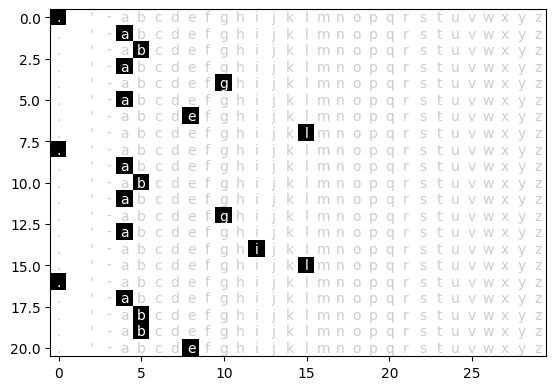

In [46]:
plt.imshow(xenc, cmap='Greys')

for y, row in enumerate(xenc):
    for x, value in enumerate(row):
        if value == 1:
            color = 'white'
            alpha = 1
        else:
            color = 'black'
            alpha = 0.2
        plt.text(x, y, letters[x], ha='center', va='center', color=color, alpha=alpha)

## Set up the network and train it

In [54]:
W = torch.randn((num_letters, num_letters), requires_grad=True).float()

In [60]:
for i in range(1000):
    W.grad = None

    logits = xenc @ W
    probs = logits.softmax(dim=0)

    # the predicted probability of the correct letter
    # from our model
    ypred = probs[torch.arange(len(ys)), ys]
    loss = -(ypred.log().sum()) / len(ys)

    if i % 50 == 0:
        print(f"Iteration {i} Loss: {loss}")
    
    loss.backward()
    W.data += -10 * W.grad

Iteration 0 Loss: 10.028895378112793
Iteration 50 Loss: 9.963700294494629
Iteration 100 Loss: 9.963600158691406
Iteration 150 Loss: 9.963565826416016
Iteration 200 Loss: 9.963544845581055
Iteration 250 Loss: 9.963545799255371
Iteration 300 Loss: 9.963547706604004
Iteration 350 Loss: 9.963539123535156
Iteration 400 Loss: 9.963523864746094
Iteration 450 Loss: 9.963543891906738
Iteration 500 Loss: 9.96351146697998
Iteration 550 Loss: 9.963521003723145
Iteration 600 Loss: 9.963526725769043
Iteration 650 Loss: 9.963530540466309
Iteration 700 Loss: 9.96351432800293
Iteration 750 Loss: 9.963510513305664
Iteration 800 Loss: 9.963513374328613
Iteration 850 Loss: 9.963513374328613
Iteration 900 Loss: 9.963522911071777
Iteration 950 Loss: 9.963521003723145


The training loop took a few tries to get right.

It took me a long time to figure out how to index into the predictions of the network `ypred` with the expected outputs `ys`. `ypred[ys]` by itself didn't work. 

But `ypred[torch.arange(len(ys)), ys]` did work. I tried it on a small toy example, before running it on the full dataset.

I also got the loss function wrong on the first try.

`ypred` is the predicted probability of the correct letter.

I thought that since I needed `ypred` to equal 1, the loss function for each example should be:

$$ \text{Loss for one example} = 1 - \text{ypred} $$

and then for all examples it should be:

$$ \text{Loss for all examples} = \sum_{\text{over all examples}}{\log (1 - \text{ypred})} $$

But it turns out the second statement is wrong. If `ypred` equals 1, we'll end up taking $\log 0$ for each example, which is $-\infty$.

Instead, the correct loss functions are as follows:

$$ \text{Loss for one example} = -\log \text{ypred} $$

$$ \text{Loss for all examples} = \sum_{\text{over all examples}}{-\log \text{ypred}} $$

This gives us a loss of 0 when the results are perfect, and a positive loss otherwise.


## Sampling words from our model

In [61]:
g = torch.Generator().manual_seed(0)

for i in range(50):
    letter = '.'

    word = ''

    while True:
        predxenc = F.one_hot(torch.tensor(ltoi[letter]), num_classes=num_letters).float()

        logits = predxenc @ W
        probs = logits.softmax(dim=0)

        next_letter_ix = torch.multinomial(probs, num_samples=1, replacement=True, generator=g)
        letter = itol[next_letter_ix.item()]

        if letter == '.':
            break

        word += letter
    print(word)






wnixithandifffffffffffffffffffffffflonngn
phinn
zzzifux-ju'ln
fzy
jucquxaqch dobbbbbbbdgwhevv'lch
mmbynngwnvvishidrbbbqugw'tcqus'cqumrgghonn-mmmand'pphxrnnngwwnevvivvy-ckadoxgwisshath'lly
gwnnd'llvvvvrcqunnggwmbbybbbbbry
fffffrghrbrgwvvinnncqun-gwiquf devvv aghernzzzzzux
kkquzzbbbelbbbotttthowhelvqusha -jon
jhyongwingwndiqudgwn-xyllvaffffffffusshruckquckqudufffffffffffflsqubbbbellbughfuzquxx zzulith
wn-gwnnthexyngwnnddux
dgw-jquzzqu
v'llaghetadinerttibenjuzkqubwenntthe-juxandan
brgwn
brtnzzmoux
my
fapgwnndsttthnntthysth'llfffffffrysh'llovvrgw-mmbbrggwinjoleloxnttaquzzzqucha-mmmiqux
bbbbbbrqusbishergwiskthjofffynkqux
gqubbbbbbadoggwn
kattttanckaqulvvibwngnlynzzz mbbbbbbebbbbbrtth
hixquxish
f'llwngwphan
ffffffffffndgwvva
kivinncyshaubux
mbobe-jondwnndux
jorhennnnnd'thynnzzkinndzmmmmunnnshzzzz-jurckqux
fwnd'th'duch
jucquzstthrrmaulghjuzzz-m'supph
jombbufffffffffrthabuxxi
phommo-mmph'webbbbbbbbe d
a-jun
jobbbbbbbbbulyth
much
juchrjubbbblammonkqureldownex
ffffflllwnyngwnncqux-jyshx
fffffikq